In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
import math
import seaborn as sns
import xgboost as xgb
from skopt import BayesSearchCV
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv', index_col='Date', parse_dates=True, low_memory=False)
df.sort_values(by='Date', inplace=True)

In [3]:
store = pd.read_csv('store.csv', low_memory=False)

In [4]:
train = df[0:math.ceil(df.shape[0]*0.8)]
test = df[train.shape[0]:df.shape[0]]

In [5]:
test.tail()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-04-30,746,4,9469,748,1,1,0,0
2015-04-30,747,4,12123,1017,1,1,0,0
2015-04-30,748,4,9524,746,1,1,0,0
2015-04-30,742,4,12225,1196,1,1,0,0
2015-04-30,1,4,6228,650,1,1,0,0


In [6]:
train.tail()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2014-11-09,156,7,0,0,0,0,0,0
2014-11-09,154,7,0,0,0,0,0,0
2014-11-09,153,7,0,0,0,0,0,0
2014-11-09,152,7,0,0,0,0,0,0
2014-11-09,151,7,0,0,0,0,0,0


In [7]:
train.isnull().sum()

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [8]:
test.isnull().sum()

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [9]:
# x_train[pd.isnull(x_train.Open)]

In [10]:
# x_train.fillna(1, inplace = True)

In [11]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear


train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

C:\Users\cuburt.balanon\AppData\Local\Temp\ipykernel_36484\1638829526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Year'] = train.index.year
C:\Users\cuburt.balanon\AppData\Local\Temp\ipykernel_36484\1638829526.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Month'] = train.index.month
C:\Users\cuburt.balanon\AppData\Local\Temp\ipykernel_36484\1638829526.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

count    608007.000000
mean          9.366660
std           2.160887
min           0.000000
25%           7.798910
50%           9.125214
75%          10.751448
max          64.957854
Name: SalePerCustomer, dtype: float64

In [12]:
train[(train.Open == 0) & (train.Sales == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2013-01-01,1115,2,0,0,0,0,a,1,2013,1,1,1,NaN
2013-01-01,379,2,0,0,0,0,a,1,2013,1,1,1,NaN
2013-01-01,378,2,0,0,0,0,a,1,2013,1,1,1,NaN
2013-01-01,377,2,0,0,0,0,a,1,2013,1,1,1,NaN
2013-01-01,376,2,0,0,0,0,a,1,2013,1,1,1,NaN


In [13]:
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head(5)

In total:  (51, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2013-01-17,762,4,0,0,1,0,0,0,2013,1,17,3,NaN
2013-01-24,232,4,0,0,1,1,0,0,2013,1,24,4,NaN
2013-01-30,339,3,0,0,1,0,0,0,2013,1,30,5,NaN
2013-01-31,339,4,0,0,1,0,0,0,2013,1,31,5,NaN
2013-02-07,259,4,0,0,1,1,0,0,2013,2,7,6,NaN


In [14]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [15]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [16]:
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [17]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [18]:
_ = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

In [19]:
store.fillna(0, inplace = True)

In [20]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train.reset_index(inplace=True)
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
# train_store.drop(columns='index')

Joining train set with an additional store information.
In total:  (731704, 23)


In [21]:
train_store

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2013-01-01,1115,2,0,0,0,0,a,1,2013,...,NaN,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1,2013-01-02,1115,3,3697,305,1,0,0,1,2013,...,12.121311,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
2,2013-01-03,1115,4,4297,300,1,0,0,1,2013,...,14.323333,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
3,2013-01-04,1115,5,4540,326,1,0,0,1,2013,...,13.926380,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
4,2013-01-05,1115,6,4771,339,1,0,0,1,2013,...,14.073746,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731699,2014-11-04,988,2,5095,753,1,1,0,0,2014,...,6.766268,a,a,30.0,11.0,2012.0,0,0.0,0.0,0
731700,2014-11-05,988,3,4334,682,1,1,0,0,2014,...,6.354839,a,a,30.0,11.0,2012.0,0,0.0,0.0,0
731701,2014-11-06,988,4,5127,776,1,1,0,0,2014,...,6.606959,a,a,30.0,11.0,2012.0,0,0.0,0.0,0
731702,2014-11-07,988,5,4890,723,1,1,0,0,2014,...,6.763485,a,a,30.0,11.0,2012.0,0,0.0,0.0,0


In [22]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,396792.0,5671.162092,3920.836667,0.0,3467.0,5541.0,7763.0,38025.0
b,11386.0,9731.467240,5287.243950,0.0,5941.0,8727.0,12681.0,37403.0
c,98418.0,5626.267725,3667.966523,0.0,3716.0,5667.0,7705.0,31448.0
d,225108.0,5521.770923,3396.095491,0.0,3903.0,5700.0,7525.0,38037.0


In [23]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

C:\Users\cuburt.balanon\AppData\Local\Temp\ipykernel_36484\3647216997.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_store.groupby('StoreType')['Customers', 'Sales'].sum()


,Customers,Sales
StoreType,,
a,261931727,2250271749
b,22214451,110802486
c,66030011,553726017
d,112039992,1242994809


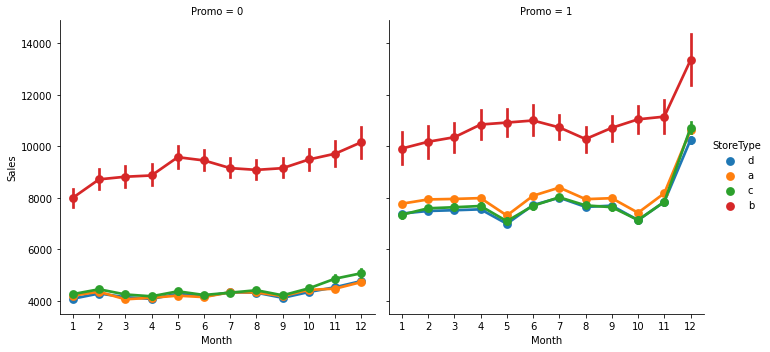

In [24]:
sns.catplot(x="Month", y="Sales", hue="StoreType",col="Promo", kind="point", data=train_store)

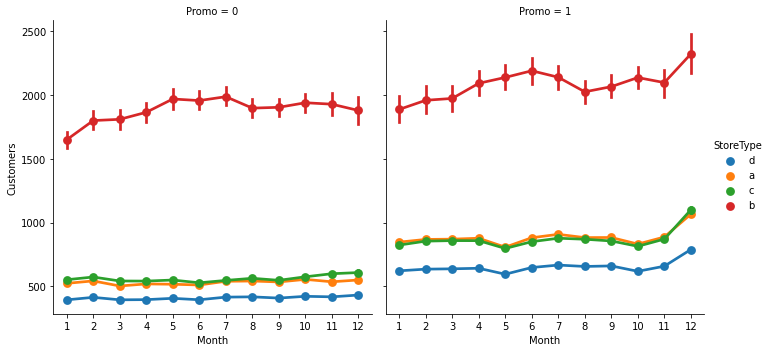

In [25]:
sns.catplot(x="Month", y="Customers", hue="StoreType",col="Promo", kind="point", data=train_store)

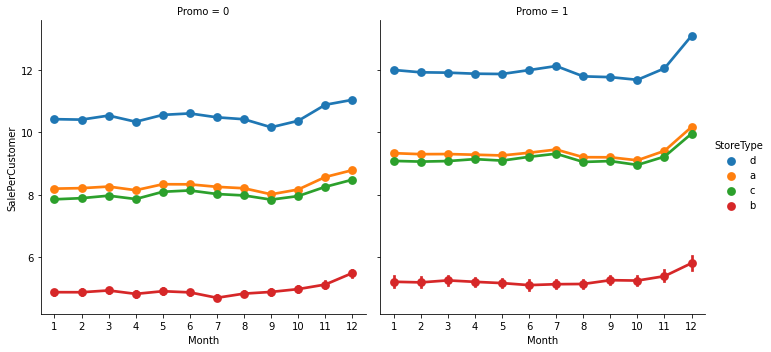

In [26]:
sns.catplot(x="Month", y="SalePerCustomer", hue="StoreType",col="Promo", kind="point", data=train_store)

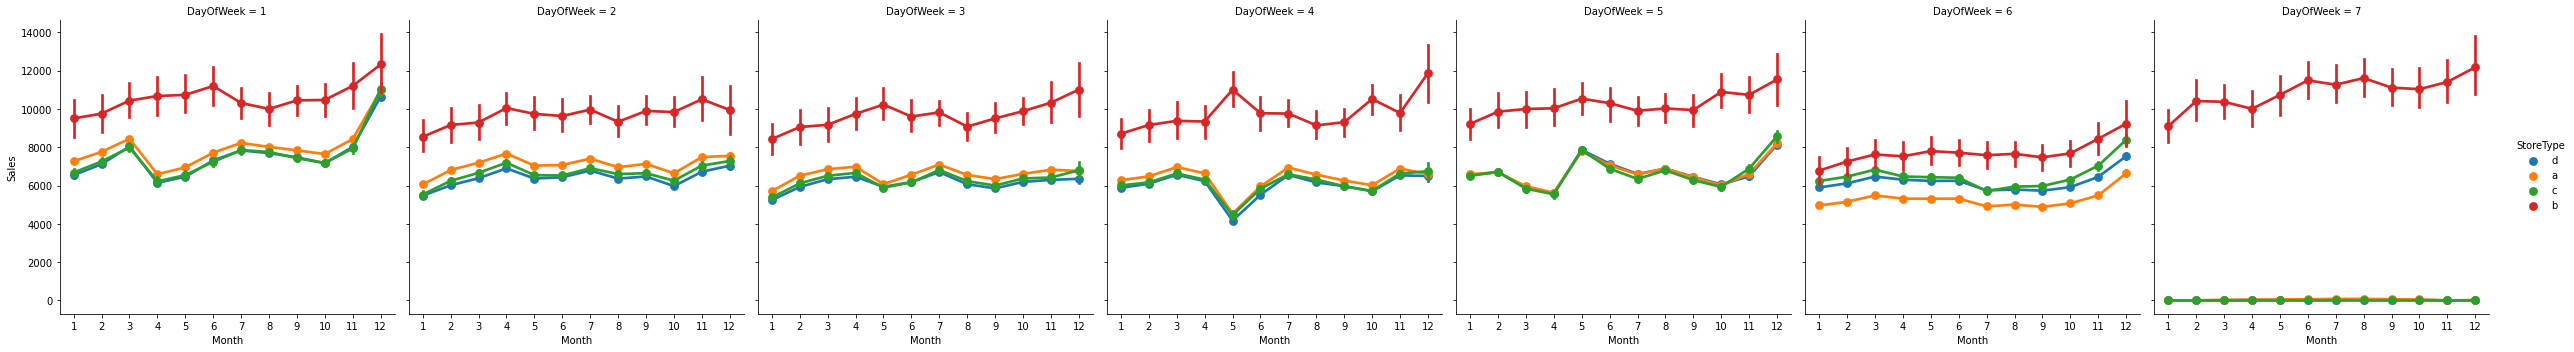

In [27]:
sns.catplot(x="Month", y="Sales", hue="StoreType",col="DayOfWeek", kind="point", data=train_store)

In [28]:
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([ 353,  310,  299,  335,  512,  494,  524,  530,  433,  423,  453,
         85,  122,  209,  274,  262,  259,  931,  948,  867,  863,  877,
       1099, 1097, 1081, 1045,  682,  676,  578,  562,  769,  732,  733],
      dtype=int64)

In [29]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + (train_store.Month - train_store.CompetitionOpenSinceMonth)

# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,5671.162092,660.123508,12876.017206,7118.232855
b,9731.467240,1951.032057,17256.876273,11262.425698
c,5626.267725,670.913969,12122.397928,6734.934311
d,5521.770923,497.716616,10391.375736,9033.309274


C:\Users\cuburt.balanon\AppData\Local\Temp\ipykernel_36484\1075848621.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_all, dtype = np.bool)


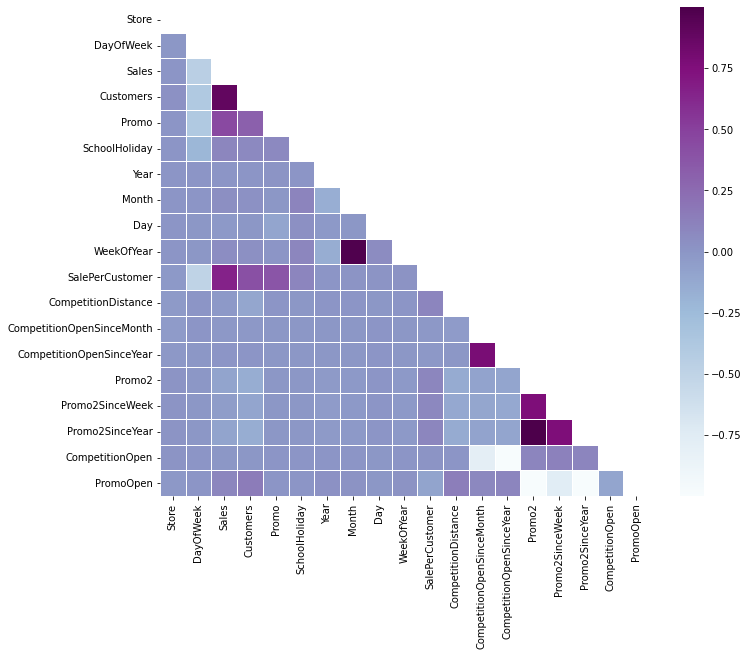

In [30]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

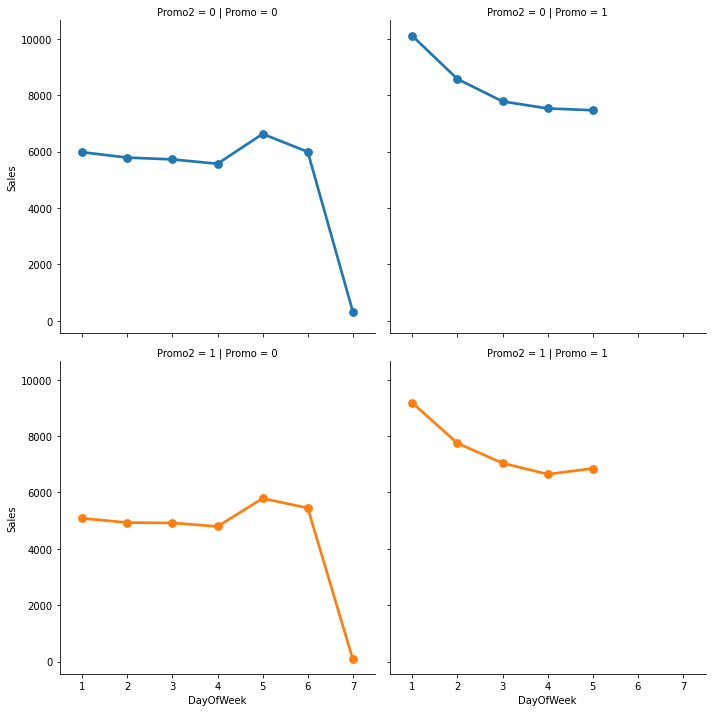

In [31]:
sns.catplot(x="DayOfWeek", y="Sales", hue="Promo2",col="Promo",row="Promo2", kind="point", data=train_store)

In [32]:
# plt.figure(figsize=(100,10))
df_copy = train_store.copy()
df_copy.set_index('Date', inplace=True)

In [33]:
df_copy.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpen,PromoOpen
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1115,2,0,0,0,0,a,1,2013,1,...,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",24157.0,6.75
2013-01-02,1115,3,3697,305,1,0,0,1,2013,1,...,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",24157.0,6.75
2013-01-03,1115,4,4297,300,1,0,0,1,2013,1,...,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",24157.0,6.75
2013-01-04,1115,5,4540,326,1,0,0,1,2013,1,...,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",24157.0,6.75
2013-01-05,1115,6,4771,339,1,0,0,1,2013,1,...,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",24157.0,6.75


In [34]:
ave_df = pd.DataFrame(df_copy.Sales.resample('D').mean())

In [35]:
ave_df.head()

,Sales
Date,
2013-01-01,87.284560
2013-01-02,6233.030493
2013-01-03,5693.112108
2013-01-04,5954.218834
2013-01-05,5337.751570


In [36]:
# for i in [x for x in train_store['StoreType'].values]:
#     df_copy = df_copy.loc[df_copy.StoreType == i]
#     ave_df = pd.DataFrame(df_copy.Sales.resample('D').mean())

#     plt.plot(ave_df.Sales)
# plt.title('Rossmann Sales')
# plt.ylabel('Sales')

In [37]:
test.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2014-11-09,150,7,0,0,0,0,0,0
2014-11-09,148,7,0,0,0,0,0,0
2014-11-09,147,7,0,0,0,0,0,0
2014-11-09,146,7,0,0,0,0,0,0
2014-11-09,178,7,0,0,0,0,0,0


In [38]:
test.isnull().sum()

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [39]:
# test[pd.isnull(test.Open)]
# test.fillna(1, inplace = True)

In [40]:
# data extraction
test['Year'] = test.index.year
test['Month'] = test.index.month
test['Day'] = test.index.day
test['WeekOfYear'] = test.index.weekofyear

# to numerical
mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
test.StateHoliday.replace(mappings, inplace = True)

train_store.Assortment.replace(mappings, inplace = True)
train_store.StoreType.replace(mappings, inplace = True)
train_store.StateHoliday.replace(mappings, inplace = True)
train_store.drop('PromoInterval', axis = 1, inplace = True)

store.StoreType.replace(mappings, inplace = True)
store.Assortment.replace(mappings, inplace = True)
store.drop('PromoInterval', axis = 1, inplace = True)

C:\Users\cuburt.balanon\AppData\Local\Temp\ipykernel_36484\1691009162.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Year'] = test.index.year
C:\Users\cuburt.balanon\AppData\Local\Temp\ipykernel_36484\1691009162.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Month'] = test.index.month
C:\Users\cuburt.balanon\AppData\Local\Temp\ipykernel_36484\1691009162.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [41]:
print("Joining test set with an additional store information.")
test_store = pd.merge(test, store, how = 'inner', on = 'Store')

test_store['CompetitionOpen'] = 12 * (test_store.Year - test_store.CompetitionOpenSinceYear) + (test_store.Month - test_store.CompetitionOpenSinceMonth)
test_store['PromoOpen'] = 12 * (test_store.Year - test_store.Promo2SinceYear) + (test_store.WeekOfYear - test_store.Promo2SinceWeek) / 4.0

print("In total: ", test_store.shape)
test_store.head()

Joining test set with an additional store information.
In total:  (182925, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen
0,150,7,0,0,0,0,0,0,2014,11,...,3,3,31830.0,3.0,2010.0,0,0.0,0.0,56.0,24179.25
1,150,1,10960,1017,1,1,0,0,2014,11,...,3,3,31830.0,3.0,2010.0,0,0.0,0.0,56.0,24179.50
2,150,2,8649,787,1,1,0,0,2014,11,...,3,3,31830.0,3.0,2010.0,0,0.0,0.0,56.0,24179.50
3,150,3,8854,823,1,1,0,0,2014,11,...,3,3,31830.0,3.0,2010.0,0,0.0,0.0,56.0,24179.50
4,150,4,9117,844,1,1,0,0,2014,11,...,3,3,31830.0,3.0,2010.0,0,0.0,0.0,56.0,24179.50


In [42]:
# split into training and evaluation sets
# excluding Sales and Id columns\
# train_store.drop(columns="Date", inplace=True)
train_store['Sales'] = train_store['Sales'] * 1.0
test['Sales'] = test['Sales'] * 1.0
predictors = [x for x in train_store.columns if x in ['Store', 'DayOfWeek', 'Customers', 'Day', 'Month', 'Year', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']]
y = train_store.Sales # log transformation of Sales
X = train_store

# split the data into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, # 30% for the evaluation set
                                                    random_state = 42)

C:\Users\cuburt.balanon\AppData\Local\Temp\ipykernel_36484\869725172.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Sales'] = test['Sales'] * 1.0


In [43]:
y_train

568187     4654.0
621543     5055.0
206045     9713.0
378669     5630.0
395637     4757.0
           ...   
259178     9339.0
365838    24523.0
131932     9804.0
671155     4677.0
121958     6893.0
Name: Sales, Length: 585363, dtype: float64

In [44]:
# evaluation metric: rmspe
# Root Mean Square Percentage Error
# code chunk shared at Kaggle

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat / y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

In [45]:
# base parameters
params = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', # regression task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.85, # 85% of features used
    'eta': 0.05, 
    'max_depth': 10, 
    'seed': 42} # for reproducible results

In [46]:
X_train[predictors].head()

,Store,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day
568187,631,6,599,1,0,0,0,2013,12,28
621543,618,4,399,1,1,0,0,2013,2,7
206045,104,3,1295,1,1,0,1,2013,6,19
378669,920,6,571,1,0,0,0,2013,12,7
395637,963,6,451,1,0,0,0,2013,12,28


In [47]:
# # XGB with xgboost library
# dtrain = xgb.DMatrix(X_train[predictors], y_train)
# dtest = xgb.DMatrix(X_test[predictors], y_test)

# watchlist = [(dtrain, 'train'), (dtest, 'test')]

# xgb_model = xgb.train(params, dtrain, 300, evals = watchlist,
#                       early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)

In [48]:
initial_model = xgb.XGBRegressor()

In [49]:
parameters = { 'nthread':[4], #when use hyperthread, xgboost may become slower
                                    'objective':['reg:linear'],
                                    'learning_rate': [.03, 0.05, .07], 
                                    'max_depth': [5, 6, 7],
                                    'min_child_weight': [4],
                                    'silent': [1],
                                    'subsample': [0.7],
                                    'colsample_bytree': [0.7],
                                    'n_estimators': [500]}

In [50]:
def get_tuned_model(X_train_data, X_test_data, y_train_data, y_test_data,
                       model, param_grid, cv=5, scoring_fit='neg_mean_squared_error',
                   do_probabilities = False):

        """ Tuned parameter for regression algorithms (ex: XGBoost model (Regressor) ) """
        bo = BayesSearchCV(model, param_grid, cv=cv, n_jobs=-1, scoring=scoring_fit, verbose=2)
                    
        # gs = GridSearchCV(
        #     estimator=model,
        #     param_grid=param_grid, 
        #     cv=cv, 
        #     n_jobs=-1, 
        #     scoring=scoring_fit,
        #     verbose=2
        # )
        fitted_model = bo.fit(X_train_data, y_train_data)

        #if do_probabilities:
        #   pred = fitted_model.predict_proba(X_test_data)
        #else:
        pred = fitted_model.predict(X_test_data)

        return fitted_model, pred

In [51]:
cv, scoring_fit = 5, 'neg_mean_squared_error'
tuned_model, pred = get_tuned_model(X_train[predictors], X_test[predictors], y_train, y_test, initial_model, parameters, cv, scoring_fit)
best_params = tuned_model.best_params_

model = xgb.XGBRegressor(objective = 'reg:squarederror',
           colsample_bytree = best_params["colsample_bytree"],
           learning_rate = best_params["learning_rate"],
           max_depth = best_params["max_depth"],
           min_child_weight = best_params["min_child_weight"],
           n_estimators = best_params["n_estimators"],
           subsample = best_params["subsample"])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\skopt\optimizer\optimizer.py:463: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[23:42:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[23:42:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


########################## fit the model #####################


NameError: name 'evalset' is not defined

In [56]:
model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.07, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [59]:
import os
import joblib
from pathlib import Path

local_model_storage_path = os.path.join("model_storage", f"rosmann.sav")
Path(local_model_storage_path).parent.mkdir(parents=True, exist_ok=True)
joblib.dump(model, local_model_storage_path)

['model_storage\\rosmann.sav']

In [60]:
rosmann_model = joblib.load(local_model_storage_path)

In [61]:
rosmann_model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.07, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [62]:
evalset = [(X_train[predictors], y_train), (X_test[predictors],y_test)]
print("########################## fit the model #####################")

model.fit(X_train[predictors], y_train, eval_metric='rmse', eval_set=evalset)
score = model.score(X_train[predictors], y_train)  
print(f"Training score: {score}")

print("########################## Cross-Validation #####################")

cross_validation_score = cross_val_score(model, X_train[predictors], y_train, cv=5)
print(f"Mean cross-validation score:, {cross_validation_score.mean()}")


########################## fit the model #####################


C:\Users\cuburt.balanon\Anaconda3\envs\regression\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:6370.95357	validation_1-rmse:6386.83296
[1]	validation_0-rmse:5947.65125	validation_1-rmse:5962.62531
[2]	validation_0-rmse:5552.72602	validation_1-rmse:5566.97055
[3]	validation_0-rmse:5228.11143	validation_1-rmse:5242.65744
[4]	validation_0-rmse:4886.60933	validation_1-rmse:4900.42636
[5]	validation_0-rmse:4571.95797	validation_1-rmse:4585.21001
[6]	validation_0-rmse:4313.05879	validation_1-rmse:4326.46464
[7]	validation_0-rmse:4094.46792	validation_1-rmse:4108.04760
[8]	validation_0-rmse:3837.33789	validation_1-rmse:3850.37401
[9]	validation_0-rmse:3633.76951	validation_1-rmse:3647.02567
[10]	validation_0-rmse:3411.98661	validation_1-rmse:3424.77589
[11]	validation_0-rmse:3239.28685	validation_1-rmse:3252.35703
[12]	validation_0-rmse:3048.89791	validation_1-rmse:3061.73413
[13]	validation_0-rmse:2873.00295	validation_1-rmse:2885.68918
[14]	validation_0-rmse:2712.11180	validation_1-rmse:2724.39934
[15]	validation_0-rmse:2590.81795	validation_1-rmse:2603.23335
[1

NameError: name 'self' is not defined

In [81]:
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, mean_absolute_error,
                             mean_absolute_percentage_error,
                             mean_squared_error, mean_squared_log_error,
                             r2_score, roc_auc_score, roc_curve)
import json
def regression_metrics(y_test, y_pred, metrics_path):

    """Evalutation metrics for regression models."""
    errorsmsg = ""
    try:
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred, multioutput='variance_weighted')
        mean_absolute_percentage_error_score = mean_absolute_percentage_error(y_test.tolist(),
                                                                              y_pred.tolist())

        print("R2:  %.2f" % r2)
        print("Mean Squared Error: %.2f" % mse)
        print("Root Mean Squared Error: %.2f" % rmse)
        print("Mean Absolute Error:  %.2f" % mae)
        print("Mean Absolute Percentage Error:  %.2f" % mean_absolute_percentage_error_score)

        mlpipeline_metrics = {"metrics":[{"name":"R2", "numberValue":r2, "format":"RAW"},
                {"name":"Mean Squared Error", "numberValue":mse, "format":"RAW"},
                {"name":"Root Mean Squared Error", "numberValue":rmse, "format":"RAW"},
                {"name":"Mean Absolute Error","numberValue":mae, "format":"RAW"},
                 {"name":"Mean Absolute Percentage Error","numberValue":mean_absolute_percentage_error_score, "format":"RAW"}]}

        Path(metrics_path).parent.mkdir(parents=True, exist_ok=True)        

        with open(metrics_path, "w") as f1:
            json.dump(mlpipeline_metrics, f1)

    except Exception as e:
        print(str(e))
        errorsmsg = str(e)
    return errorsmsg

In [82]:
local_metrics_storage_path = "metrics_storage"

########################## Model-Prediction #####################
R2:  0.97
Mean Squared Error: 413766.40
Root Mean Squared Error: 643.25
Mean Absolute Error:  438.98
Mean Absolute Percentage Error:  85374846496098192.00
#################################### RESULTS PLOTTING  START ####################


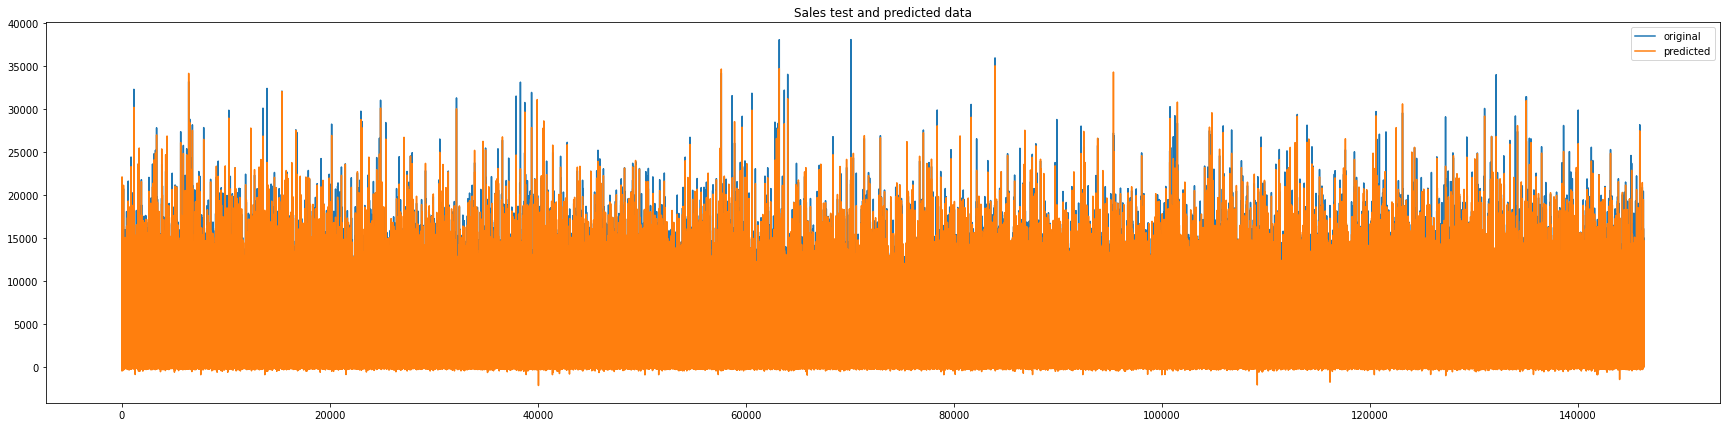

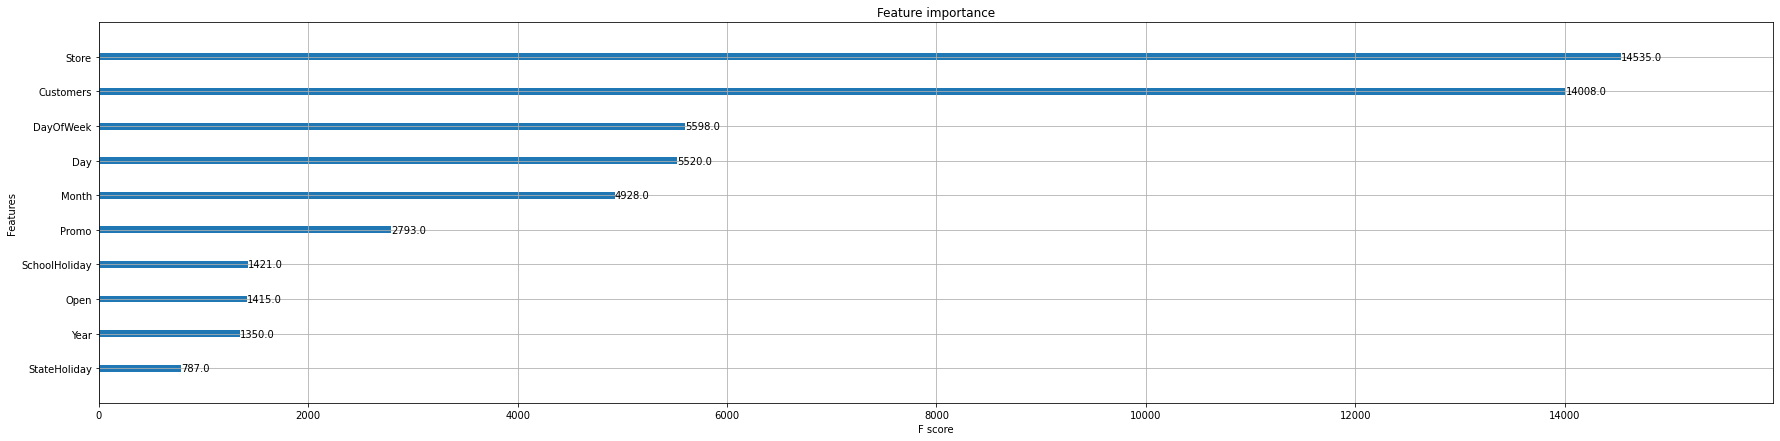

####################################RESULTS PLOTTING END ####################


In [83]:
print("########################## Model-Prediction #####################")
ypred = model.predict(X_test[predictors])
error_msg = regression_metrics(y_test, ypred, local_metrics_storage_path)

print("#################################### RESULTS PLOTTING  START ####################")
if not error_msg:
    x_ax = range(len(y_test))
    plt.rcParams["figure.figsize"] = (30, 7)
    plt.plot(x_ax, y_test, label="original")
    plt.plot(x_ax, ypred, label="predicted")
    plt.title("Sales test and predicted data")
    plt.legend()
    plt.show()
    xgb.plot_importance(model, max_num_features = 15)
    plt.show()
print("####################################RESULTS PLOTTING END ####################")

In [ ]:
request = {
"Store": 1111,
"DayOfWeek": 4,
"Date": "2014-07-10",
"Customers": 410,
"Open": 1,
"Promo": 0,
"StateHoliday": "0",
"SchoolHoliday": 1
}

In [173]:
X_train

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen
568187,2013-12-28,631,6,4654.0,599,1,0,0,0,2013,...,4,3,2870.0,0.0,0.0,1,35.0,2012.0,24168.0,16.25
621543,2013-02-07,618,4,5055.0,399,1,1,0,0,2013,...,4,3,9910.0,0.0,0.0,0,0.0,0.0,24158.0,24157.50
206045,2013-06-19,104,3,9713.0,1295,1,1,0,1,2013,...,1,1,390.0,6.0,2009.0,0,0.0,0.0,48.0,24162.25
378669,2013-12-07,920,6,5630.0,571,1,0,0,0,2013,...,1,1,850.0,2.0,2012.0,1,40.0,2014.0,22.0,-9.75
395637,2013-12-28,963,6,4757.0,451,1,0,0,0,2013,...,1,3,23620.0,11.0,2013.0,0,0.0,0.0,1.0,24169.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,2014-10-09,57,4,9339.0,924,1,1,0,0,2014,...,4,3,420.0,6.0,2014.0,0,0.0,0.0,4.0,24178.25
365838,2013-08-30,1114,5,24523.0,3837,1,1,0,0,2013,...,1,3,870.0,0.0,0.0,0,0.0,0.0,24164.0,24164.75
131932,2013-06-12,532,3,9804.0,1161,1,0,0,0,2013,...,1,3,1070.0,8.0,2010.0,0,0.0,0.0,34.0,24162.00
671155,2013-07-04,823,4,4677.0,496,1,1,0,1,2013,...,1,3,16210.0,11.0,2010.0,0,0.0,0.0,32.0,24162.75


In [103]:
model.predict((X_train[predictors].values)[[585362]])

array([6770.6406], dtype=float32)

In [181]:
request = {
    "Store": 618,
    "DayOfWeek": 4,
    "Date": "2013-02-07",
    "Customers": 399,
    "Open": 1,
    "Promo": 1,
    "StateHoliday": "0",
    "SchoolHoliday": 0
}

In [182]:
date_object = datetime.strptime(request.get('Date'), '%Y-%m-%d').date()

In [183]:
request['Year'] = date_object.year
request['Month'] = date_object.month
request['Day'] = date_object.day

mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
state_holiday = request.get('StateHoliday')
for key, value in mappings.items():
    state_holiday = state_holiday.replace(key, str(value))
request['StateHoliday'] = int(state_holiday)

In [184]:
request

{'Store': 618,
 'DayOfWeek': 4,
 'Date': '2013-02-07',
 'Customers': 399,
 'Open': 1,
 'Promo': 1,
 'StateHoliday': 0,
 'SchoolHoliday': 0,
 'Year': 2013,
 'Month': 2,
 'Day': 7}

In [185]:
a_list = ['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day']

array([[ 618,    4,  399,    1,    1,    0,    0, 2013,    2,    7]])

In [186]:
# np.array([list(request.values())])

In [188]:
output = model.predict(np.array([[i[1] for i in [(key, request[key]) for key in a_list if key in request]]]))

In [192]:
output[0]

5415.162